In [1]:
# from google.colab import drive
# drive.mount('/content/drive') #mounts google colab to my drive. Can be commented out when running locally

# %cd /content/drive/MyDrive/"Colab Notebooks"/"us-patent-phrase-to-phrase-matching"

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/us-patent-phrase-to-phrase-matching


In [ ]:
!pip install pyyaml h5py

In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, SimpleRNN, Dense, LSTM, GRU, Flatten, Dropout, Input
from keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
import keras
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

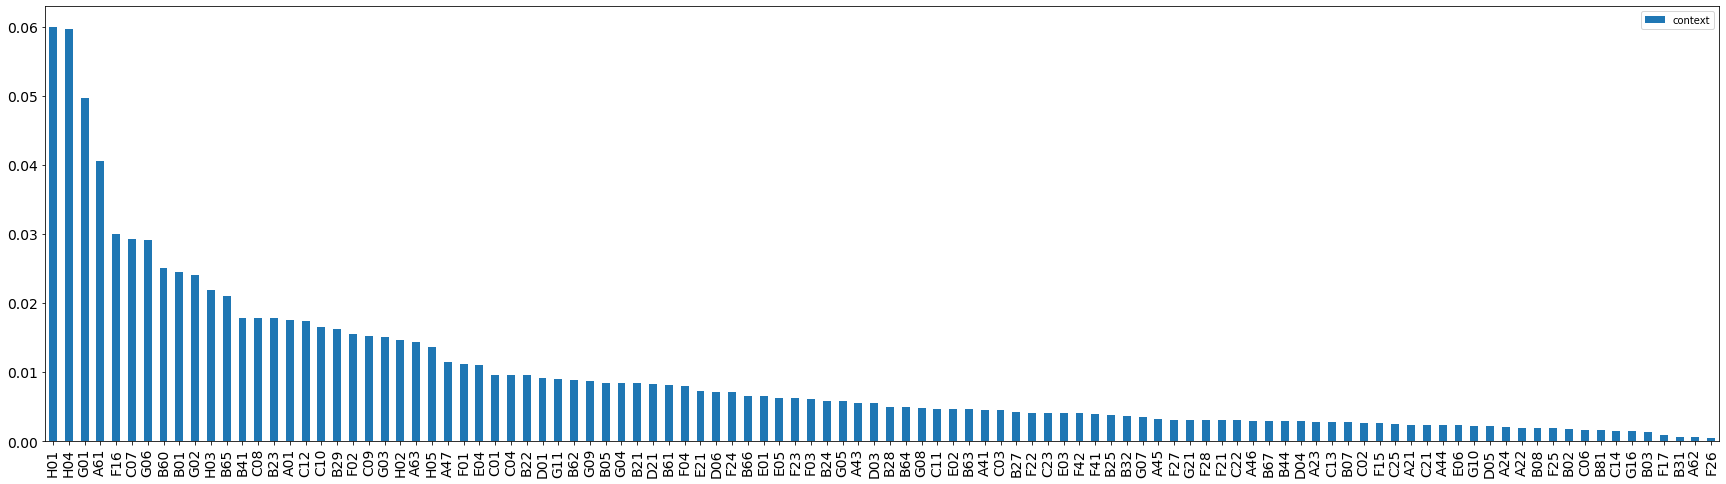

In [ ]:
context_counts = pd.DataFrame(train_df['context'].value_counts(normalize=True))
context_counts.plot(kind="bar", figsize = (30,8), fontsize=14).get_figure().savefig("context_distribution.png")

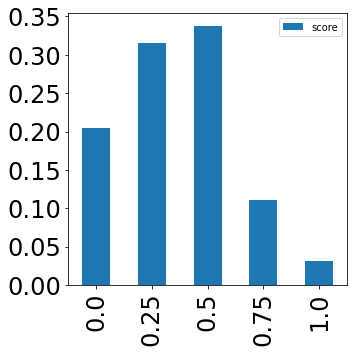

In [ ]:
score_counts = pd.DataFrame(train_df['score'].value_counts(normalize=True, sort=False)).reindex([0,.25,.5,.75,1])
score_counts.plot(kind="bar", figsize = (5,5), fontsize=24).get_figure().savefig("score_distribution.png")

In [4]:
'''preprocesses the data. Converts the labels from similarity measures to classes, then returns that in one-hot encoded form.
additionally concatenates the inputs as needed.'''
def preprocess(df):
    data = df.to_numpy()
    all_ids = data[:, 0]
    sentences = [data[i, 1].lower() + " " + data[i, 2].lower() + " " + data[i, 3].lower() for i in range(len(data))]
    classes = {0: 0, .25: 1, .5: 2, .75: 3, 1: 4}
    y_train = None
    if data.shape[1] == 5:
        y_train = [classes[val] for val in data[:, 4]]
        y_train = tf.one_hot(y_train, 5)
    return sentences, y_train

In [5]:
X_train, y_train = preprocess(train_df)
X_test, _ = preprocess(test_df)

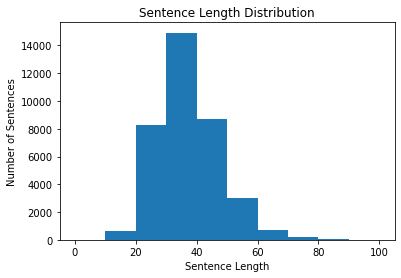

In [6]:
all_len = [len(sentence) for sentence in X_train]
plt.hist(all_len, bins=np.arange(0, 110, 10))
plt.title("Sentence Length Distribution")
plt.xlabel("Sentence Length")
plt.ylabel("Number of Sentences")
plt.show()

In [ ]:
#looking for the longest sentence to figure out the zero padding length
max_train_len = max([len(sentence) for sentence in X_train])
max_test_len = max([len(sentence) for sentence in X_test])
maxlen = max(max_train_len, max_test_len)

In [ ]:
tk = Tokenizer()
tk.fit_on_texts(X_train)
X_train = tk.texts_to_sequences(X_train)
X_test = tk.texts_to_sequences(X_test)

In [ ]:
EMBEDDING_SIZE = 128
MAX_SENTENCE_LEN = maxlen #the input sizes for the model
vocab_size = len(tk.word_index)
num_epochs=10

In [ ]:
X_train = sequence.pad_sequences(X_train, maxlen=MAX_SENTENCE_LEN, padding='post')
X_test = sequence.pad_sequences(X_test, maxlen=MAX_SENTENCE_LEN, padding='post')

In [ ]:
print(X_train.shape)

(36473, 111)


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [ ]:
def one_hot(y):
    arr = np.zeros((y.shape[0], np.max(y) + 1))
    for i in range(arr.shape[0]):
        arr[i, y[i]] = 1
    return arr

In [ ]:
#The data is then split into training and testing from the original training data. The test data provided does not contain
#labels as this is a kaggle competition.
def train_test_val_split(X_train, y_train, test_size=.2, val_size=.2, random_state=11):
    y_train_temp = np.argmax(y_train, axis=1)
    X_train_real, X_test_real, y_train_vec, y_test_vec = train_test_split(X_train, y_train_temp, test_size=test_size, random_state=random_state)
    X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X_train_real, y_train_vec, test_size=val_size, random_state=random_state)
    y_train_final = one_hot(y_train_final)
    y_val_final = one_hot(y_val_final)
    return X_train_final, X_test_real, X_val_final, y_train_final, y_test_vec, y_val_final

In [ ]:
X_tr, X_test, X_val, y_t, y_test, y_val = train_test_val_split(X_train, y_train)
model = Sequential()
model.add(Embedding(vocab_size + 1, EMBEDDING_SIZE, input_length=MAX_SENTENCE_LEN, name='input_embedding'))
model.add(Flatten(name='flatten'))
model.add(Dense(5, activation='softmax', name='output')) #the 5 classes, 0 to 4
model.compile(loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_tr, y_t, validation_data=(X_val, y_val), epochs=num_epochs)

Epoch 1/10
730/730 [==============================] - 9s 11ms/step - loss: 0.4434 - accuracy: 0.3824 - val_loss: 0.4260 - val_accuracy: 0.4381
Epoch 2/10
730/730 [==============================] - 8s 11ms/step - loss: 0.3998 - accuracy: 0.4945 - val_loss: 0.4097 - val_accuracy: 0.4674
Epoch 3/10
730/730 [==============================] - 8s 11ms/step - loss: 0.3638 - accuracy: 0.5625 - val_loss: 0.4028 - val_accuracy: 0.4993
Epoch 4/10
730/730 [==============================] - 8s 11ms/step - loss: 0.3374 - accuracy: 0.6098 - val_loss: 0.4033 - val_accuracy: 0.5039
Epoch 5/10
730/730 [==============================] - 8s 11ms/step - loss: 0.3168 - accuracy: 0.6413 - val_loss: 0.4063 - val_accuracy: 0.5081
Epoch 6/10
730/730 [==============================] - 8s 11ms/step - loss: 0.2998 - accuracy: 0.6646 - val_loss: 0.4131 - val_accuracy: 0.5086
Epoch 7/10
730/730 [==============================] - 8s 11ms/step - loss: 0.2857 - accuracy: 0.6905 - val_loss: 0.4159 - val_accuracy: 0.5101

In [ ]:
pred = model.predict(X_test)
res = np.argmax(pred, axis=1)
print("The model has an accuracy of {acc}%".format(acc=np.round(100*accuracy_score(res, y_test), 2)))

The model has an accuracy of 50.95%


In [ ]:
model.save("base_model.h5")

In [ ]:
from scipy.stats import pearsonr
r, _ = pearsonr(y_test/4, np.sum(np.arange(0, 1.25, .25) * pred, axis=1))
print("The correlation coefficient between the actual similarities and predicted similarities using a weighted average is {r}".format(r=np.round(r, 2)))

The correlation coefficient between the actual similarities and predicted similarities is 0.47


In [ ]:
r, _ = pearsonr(y_test/4, res/4)
print("The correlation coefficient between the actual similarities and predicted similarities using a hard max is {r}".format(r=np.round(r, 2)))

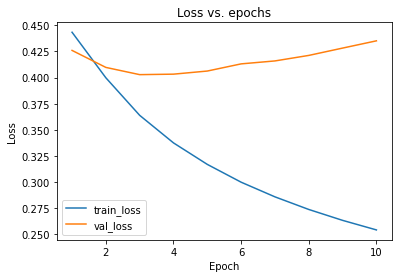

In [ ]:
plt.plot(1 + np.arange(0, num_epochs, 1), history.history['loss'], label='train_loss')
plt.plot(1 + np.arange(0, num_epochs, 1), history.history['val_loss'], label='val_loss')
plt.title("Loss vs. epochs")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig("base_loss.png")
plt.show()

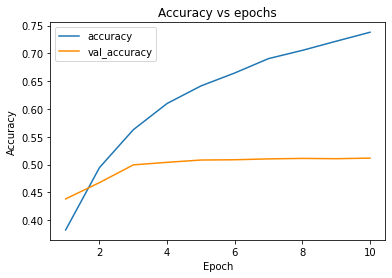

In [ ]:
plt.plot(1 + np.arange(0, num_epochs, 1), history.history['accuracy'], label='accuracy')
plt.plot(1 + np.arange(0, num_epochs, 1), history.history['val_accuracy'], label='val_accuracy', c='darkorange')
plt.title("Accuracy vs epochs")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig("base_acc.png")
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
train_df['sentence'] = train_df['anchor'].str.lower() + " " + train_df['target'].str.lower() + " " + train_df['context'].str.lower()

In [ ]:
corpus = train_df['sentence'].to_numpy()

In [ ]:
vectorizer = CountVectorizer()

In [ ]:
X_train = vectorizer.fit_transform(corpus).toarray()
X_tr, X_test, X_val, y_t, y_test, y_val = train_test_val_split(X_train, y_train)

In [ ]:
model_2 = Sequential()
model_2.add(Dense(512, name='first_dense'))
model_2.add(Dropout(rate=.4))
model_2.add(Dense(64, name='second_dense'))
model_2.add(Dropout(rate=.2))
model_2.add(Dense(5, activation='softmax', name='output'))
model_2.compile(loss='binary_crossentropy', metrics=['accuracy'])
history = model_2.fit(X_tr, y_t, validation_data=(X_val, y_val), epochs=num_epochs)

Epoch 1/10
730/730 [==============================] - 45s 60ms/step - loss: 0.4501 - accuracy: 0.3765 - val_loss: 0.4368 - val_accuracy: 0.4085
Epoch 2/10
730/730 [==============================] - 42s 57ms/step - loss: 0.4260 - accuracy: 0.4377 - val_loss: 0.4325 - val_accuracy: 0.4162
Epoch 3/10
730/730 [==============================] - 42s 57ms/step - loss: 0.4133 - accuracy: 0.4719 - val_loss: 0.4314 - val_accuracy: 0.4272
Epoch 4/10
730/730 [==============================] - 42s 57ms/step - loss: 0.4029 - accuracy: 0.4976 - val_loss: 0.4311 - val_accuracy: 0.4387
Epoch 5/10
730/730 [==============================] - 42s 57ms/step - loss: 0.3965 - accuracy: 0.5111 - val_loss: 0.4327 - val_accuracy: 0.4405
Epoch 6/10
730/730 [==============================] - 42s 57ms/step - loss: 0.3905 - accuracy: 0.5267 - val_loss: 0.4265 - val_accuracy: 0.4548
Epoch 7/10
730/730 [==============================] - 42s 58ms/step - loss: 0.3857 - accuracy: 0.5400 - val_loss: 0.4306 - val_accuracy:

In [ ]:
pred = model_2.predict(X_test)
res = np.argmax(pred, axis=1)
print("The model has an accuracy of {acc}%".format(acc=np.round(100*accuracy_score(res, y_test), 2)))

The model has an accuracy of 46.36%


In [ ]:
real_accuracy = np.sum(np.arange(0, 1.25, .25) * pred, axis=1)
r, _ = pearsonr(y_test/4, real_accuracy)
print("The correlation coefficient between the actual similarities and predicted similarities using a weighted average is {r}".format(r=np.round(r, 2)))

The correlation coefficient between the actual similarities and predicted similarities is 0.39


In [ ]:
res = np.argmax(pred, axis=1)
r, _ = pearsonr(y_test/4, res/4)
print("The correlation coefficient between the actual similarities and predicted similarities using a hard max is average is {r}".format(r=np.round(r, 2)))

In [ ]:
import matplotlib.pyplot as plt

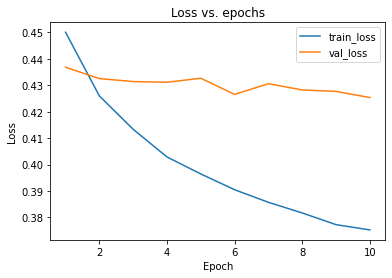

In [ ]:
plt.plot(1 + np.arange(0, num_epochs, 1), history.history['loss'], label='train_loss')
plt.plot(1 + np.arange(0, num_epochs, 1), history.history['val_loss'], label='val_loss')
plt.title("Loss vs. epochs")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig("bow_loss.png")

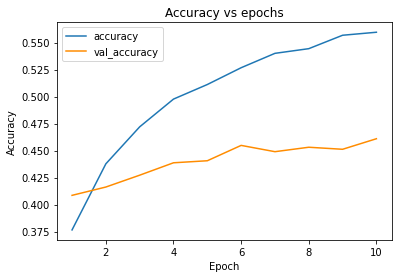

In [ ]:
plt.plot(1 + np.arange(0, num_epochs, 1), history.history['accuracy'], label='accuracy')
plt.plot(1 + np.arange(0, num_epochs, 1), history.history['val_accuracy'], label='val_accuracy', c='darkorange')
plt.title("Accuracy vs epochs")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig("bow_acc.png")
plt.show()

In [ ]:
train_df['anchor_context'] = train_df['anchor'].str.lower() + " " + train_df['context'].str.lower()
train_df['target_context'] = train_df['target'].str.lower() + " " + train_df['context'].str.lower()

In [ ]:
anchor_context = train_df['anchor_context'].to_numpy()
target_context = train_df['target_context'].to_numpy()
max_anchor_len = max([len(sentence) for sentence in anchor_context])
max_target_len = max([len(sentence) for sentence in target_context])
maxlen = max(max_anchor_len, max_target_len)
print(maxlen)

102


In [ ]:
print(anchor_context.shape)

(36473,)


In [ ]:
tk = Tokenizer()
tk.fit_on_texts(np.concatenate((anchor_context, target_context), axis=0))
anchor_token = tk.texts_to_sequences(anchor_context)
target_token = tk.texts_to_sequences(target_context)

In [ ]:
from nltk.stem import PorterStemmer
from collections import defaultdict

In [ ]:
#helper function used to count the number of duplicate stems per sentence
def count_num_duplicate_stems(arr, threshold=2):
    _, counts = np.unique(arr, return_counts=True)
    return np.count_nonzero(counts >= threshold)


In [ ]:
X_train_anchor = sequence.pad_sequences(anchor_token, maxlen=maxlen, padding='post')
X_train_target = sequence.pad_sequences(target_token, maxlen=maxlen, padding='post')
ps = PorterStemmer()
sentences = (train_df['anchor'] + " " + train_df['target']).to_numpy()
all_stems = [[ps.stem(w) for w in sentence.split()] for sentence in sentences]
all_counts = np.array([count_num_duplicate_stems(stems) for stems in all_stems]).reshape(-1, 1)

In [ ]:
#The model takes in the anchor + context, the target + context, and the number of similar stems per example. The stems of
#the words can be found using NLTK
from keras import layers
anchor_input = Input(shape=(maxlen,), name='anchor_input')
target_input = Input(shape=(maxlen,), name='target_input')
num_dup_stems = Input(shape=(1,), name='num_same_stems')
embedding = Embedding(vocab_size + 1, EMBEDDING_SIZE, input_length=maxlen, name='anchor_target_embedding')
anchor_embedding = embedding(anchor_input) #takes embeddings of target and anchor inputs
target_embedding = embedding(target_input)
final_layer = layers.concatenate([Flatten(name='anchor_flatten')(anchor_embedding), Flatten(name='target_flatten')(target_embedding), num_dup_stems])
first_dense = Dense(512, activation='relu', name='first_dense')(final_layer)
first_dense = Dropout(rate=.5)(first_dense)
second_dense = Dense(32, activation='softplus', name='second_dense')(first_dense)
second_dense = Dropout(rate=.3)(second_dense)
output = Dense(5, activation='softmax', name='y_pred')(second_dense)
model = Model([anchor_input, target_input, num_dup_stems], output)
model.compile(loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
state = 11 #used for making sure that the splits are the same for anchor and target (so they correspond to each other).
X_A_train, X_A_test, X_A_val, y_t, y_test, y_val = train_test_val_split(X_train_anchor, y_train, random_state=state)
X_T_train, X_T_test, X_T_val, _, _, _ = train_test_val_split(X_train_target, y_train, random_state=state)
X_num_train, X_num_test, X_num_val, _, _, _ = train_test_val_split(all_counts, y_train, random_state=state)
history = model.fit([X_A_train, X_T_train, X_num_train], y_t, validation_data=([X_A_val, X_T_val, X_num_val], y_val), epochs=num_epochs)

Epoch 1/10
730/730 [==============================] - 131s 178ms/step - loss: 0.4400 - accuracy: 0.4220 - auc: 0.7492 - val_loss: 0.3847 - val_accuracy: 0.5125 - val_auc: 0.8193
Epoch 2/10
730/730 [==============================] - 131s 179ms/step - loss: 0.3678 - accuracy: 0.5600 - auc: 0.8413 - val_loss: 0.3621 - val_accuracy: 0.5643 - val_auc: 0.8447
Epoch 3/10
730/730 [==============================] - 130s 178ms/step - loss: 0.3248 - accuracy: 0.6312 - auc: 0.8818 - val_loss: 0.3647 - val_accuracy: 0.5773 - val_auc: 0.8470
Epoch 4/10
730/730 [==============================] - 130s 178ms/step - loss: 0.2974 - accuracy: 0.6720 - auc: 0.9031 - val_loss: 0.3751 - val_accuracy: 0.5877 - val_auc: 0.8473
Epoch 5/10
730/730 [==============================] - 130s 178ms/step - loss: 0.2767 - accuracy: 0.7047 - auc: 0.9171 - val_loss: 0.3672 - val_accuracy: 0.5869 - val_auc: 0.8534
Epoch 6/10
730/730 [==============================] - 129s 177ms/step - loss: 0.2615 - accuracy: 0.7262 - auc:

In [ ]:
pred = model.predict([X_A_test, X_T_test, X_num_test])
res = np.argmax(pred, axis=1)
print("The model has an accuracy of {acc}%".format(acc=np.round(100*accuracy_score(res, y_test), 2)))

The model has an accuracy of 57.7%


In [ ]:
real_accuracy = np.sum(np.arange(0, 1.25, .25) * pred, axis=1)
r, _ = pearsonr(y_test/4, real_accuracy)
print("The correlation coefficient between the actual similarities and predicted similarities using a weighted average is {r}".format(r=np.round(r, 2)))

The correlation coefficient between the actual similarities and predicted similarities is 0.57


In [ ]:
hard_max = np.argmax(pred, axis=1)
r, _ = pearsonr(y_test/4, hard_max/4)
print("The correlation coefficient between the actual similarities and predicted similarities using a hard maximum is {r}".format(r=np.round(r, 2)))

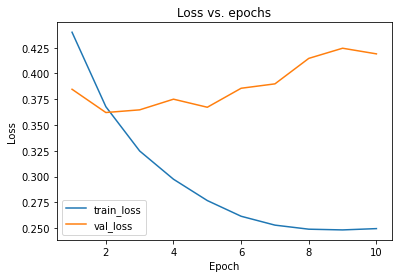

In [ ]:
plt.plot(1 + np.arange(0, 10, 1), history.history['loss'], label='train_loss')
plt.plot(1 + np.arange(0, 10, 1), history.history['val_loss'], label='val_loss')
plt.title("Loss vs. epochs")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig("stem_loss.png")
plt.show()

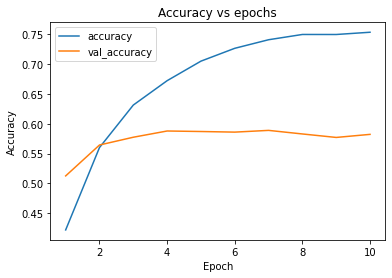

In [ ]:
plt.plot(1 + np.arange(0, 10, 1), history.history['accuracy'], label='accuracy')
plt.plot(1 + np.arange(0, 10, 1), history.history['val_accuracy'], label='val_accuracy')
plt.title("Accuracy vs epochs")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig("stem_acc.png")
plt.show()

In [ ]:
model.save("context_concat_model.h5")

In [ ]:
model_2.save("cbow_model.h5")

In [ ]:
from tensorflow.keras.utils import plot_model

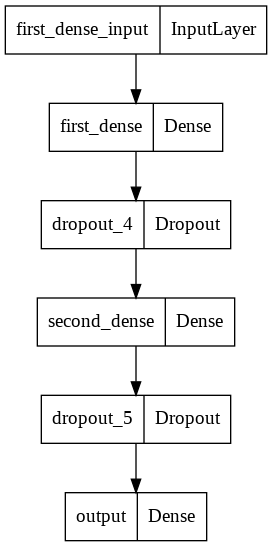

In [ ]:
plot_model(model_2)